# 8. Adaptivity, stiffness, control I

```{admonition} Additional resource
:class: warning
[Gustaf Soderlind: Digital filters in adaptive time-stepping](https://dl.acm.org/doi/abs/10.1145/641876.641877)
```

Another type of ODE on which explicit Runge-Kutta methods don't perform well are **stiff** systems. Even though the phenomenon has been in the awareness of mathematicians for a long time, there is still not one accepted definition. Some ways of describing them include

> Stiff equations are problems for which explicit methods don't work.


> An ordinary differential equation problem is stiff if the solution being sought is varying slowly, but there are nearby solutions that vary rapidly, so the numerical method must take small steps to obtain satisfactory results.

> An ODE is stiff if the stepsize of a numerical method solving it depends not only on the smoothness of the solution, but is limited by stability.

Most explicit methods indeed perform poorly when applied to stiff systems. To demonstrate, we look at the following IVP,

\begin{align}
u' &= u^2 - u^3, \quad t \in (0, \tfrac{2}{\delta}), \\
u(0) &= \delta,
\end{align}

describing the growth of the radius $u(t)$ of a spherical flame. It grows by consuming oxygen available through its "surface", which is $\propto u^2$, and burns oxygen contained in its volume, $\propto u^3$. Below is the solution as computed by an explicit 4th order Runge-Kutta method, the evolution of its stepsize during the solution, and the total number of steps it took.

In [2]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
def f(t, y):
    return y**2 - y**3
    
delta = 1e-4
t_span = (0, 2/delta)
y0 = np.array([delta])
t_eval = np.linspace(0, 2/delta, 200)
sol_exp = si.solve_ivp(f, t_span, y0, rtol = 1e-4, dense_output = True)

In [4]:
hs = np.array([sol_exp.t[i] - sol_exp.t[i-1] for i in range(1, sol_exp.t.shape[0])])
ts = np.linspace(t_span[0], t_span[1], 500)
ys = sol_exp.sol(ts)

<IPython.core.display.Javascript object>


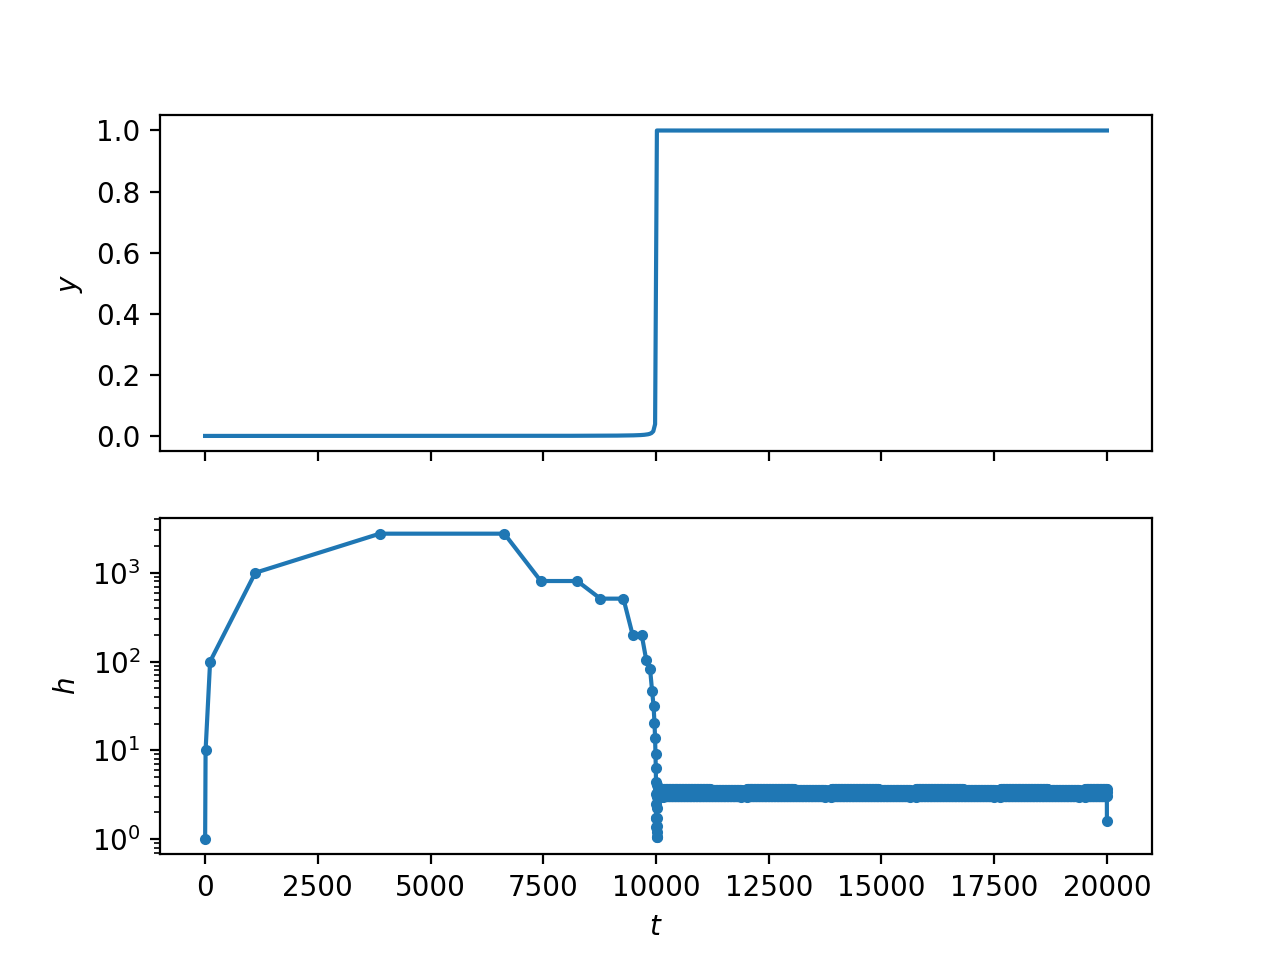

Total number of steps:  3051


In [5]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(ts, ys[0])
ax[1].semilogy(sol_exp.t[1:], hs, '.-')
ax[1].set_xlabel("$t$"); ax[0].set_ylabel("$y$"); ax[1].set_ylabel("$h$")
print("Total number of steps: ",len(sol_exp.t))

Compare that to an _implicit_ method solving the same problem below. Implicit methods have forecast functions $\Phi_h$ that depend on the solution at the end of the timestep, therefore require a linear solve to be computed,

$$ \tilde{u}_{i+1} = \Phi_h(\tilde{u}_{i+1}, \tilde{u}_i, \ldots ; t_{i+1}, t_i, \ldots; f). $$

<IPython.core.display.Javascript object>


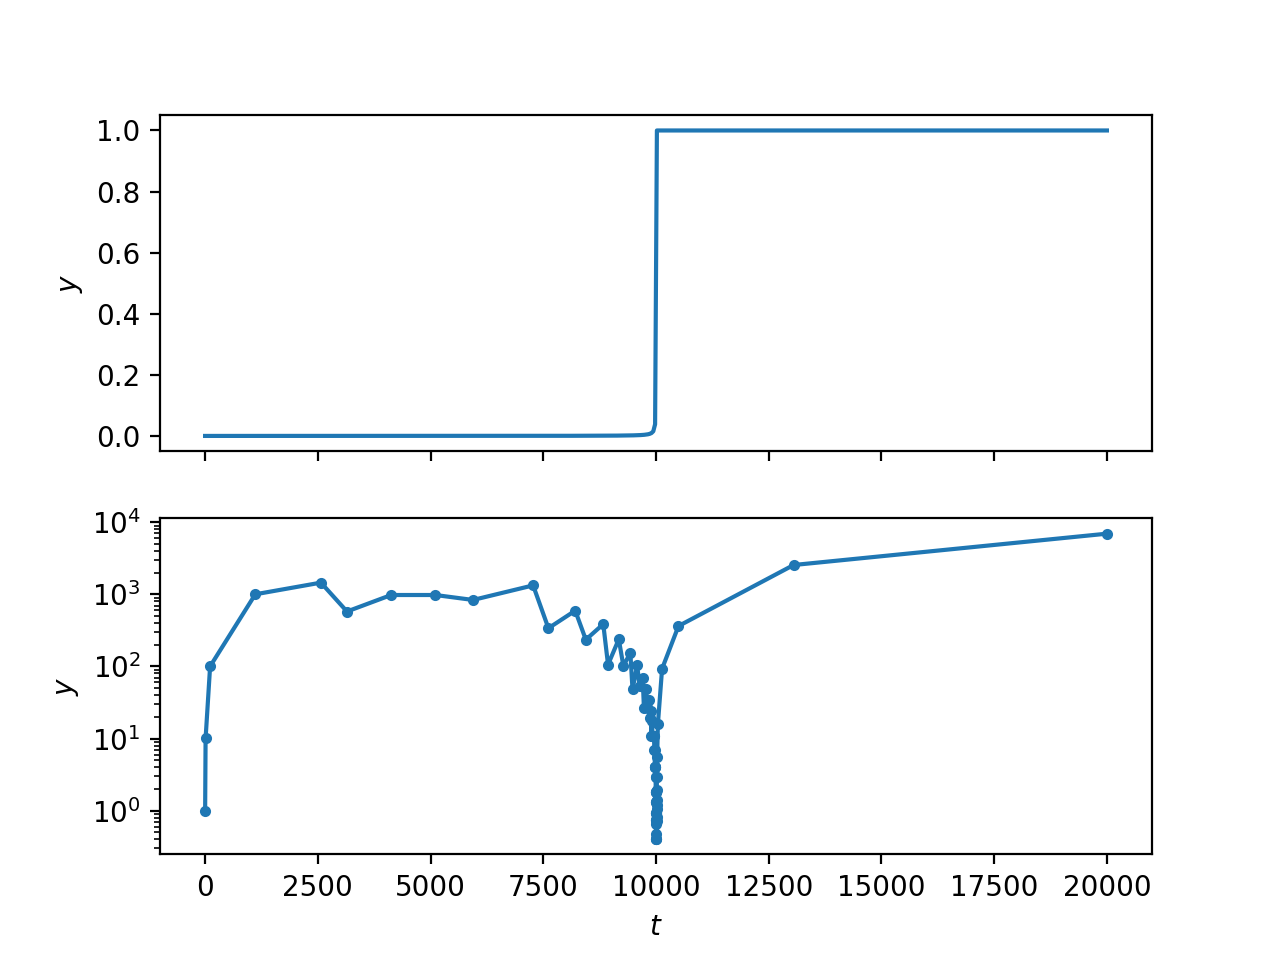

Total number of steps:  74


In [6]:
sol_imp = si.solve_ivp(f, t_span, y0, rtol = 1e-4, dense_output = True, method = "Radau")

hs = np.array([sol_imp.t[i] - sol_imp.t[i-1] for i in range(1, sol_imp.t.shape[0])])
ts = np.linspace(t_span[0], t_span[1], 500)
ys = sol_imp.sol(ts)

fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(ts, ys[0])
ax[1].semilogy(sol_imp.t[1:], hs, '.-')
ax[1].set_xlabel("$t$"); ax[0].set_ylabel("$y$"); ax[1].set_ylabel("$y$")
print("Total number of steps: ",len(sol_imp.t))

```{admonition} Question
What do you observe?
```

The implicit method takes $\approx$ 50 times fewer steps, largely in the $t > 10^4$ region of the solution, where the solution is smooth. Note that at around $t = 10^4$, where the solution jumps (is nonsmooth), both solvers reduce their stepsize in order to keep the local error below the tolerance. It is said that most explicit methods are **stability-limited** when it comes to stiff problems, which we'll define rigorously now.

## 8.1 Stability

Stability is the property of a numerical method. It is defined via the Dahlquist test equation,

```{math}
:label: dahlquist
u' = \lambda u.
```

```{admonition} Definition
:class: hint
If a numerical method computes the solution of {eq}`dahlquist` at the next timestep as
$$ u_{n+1} = R(\lambda h) u_n, $$
then $R(z)$ for $z \in \mathbb{C}$ is its **stability function**, and the area $\{z \in \mathbb{C}: |R(z)| \leq 1\}$ is its **stability region**.
```

Take a look at the stability region of the simplest explicit and implicit methods you know, the forward and backward Euler method. Forward Euler has

$$ u_{n+1} = u_n + hf(t_n, u_n) = u_n(1 + \lambda h), $$

so the stability region is $\{z \in \mathbb{C}: |1 + z| \leq 1\}$.

```{admonition} Question
What does this region look like?
```

This stability region is just a disc centered on $z = -1$, with radius 1:

<IPython.core.display.Javascript object>


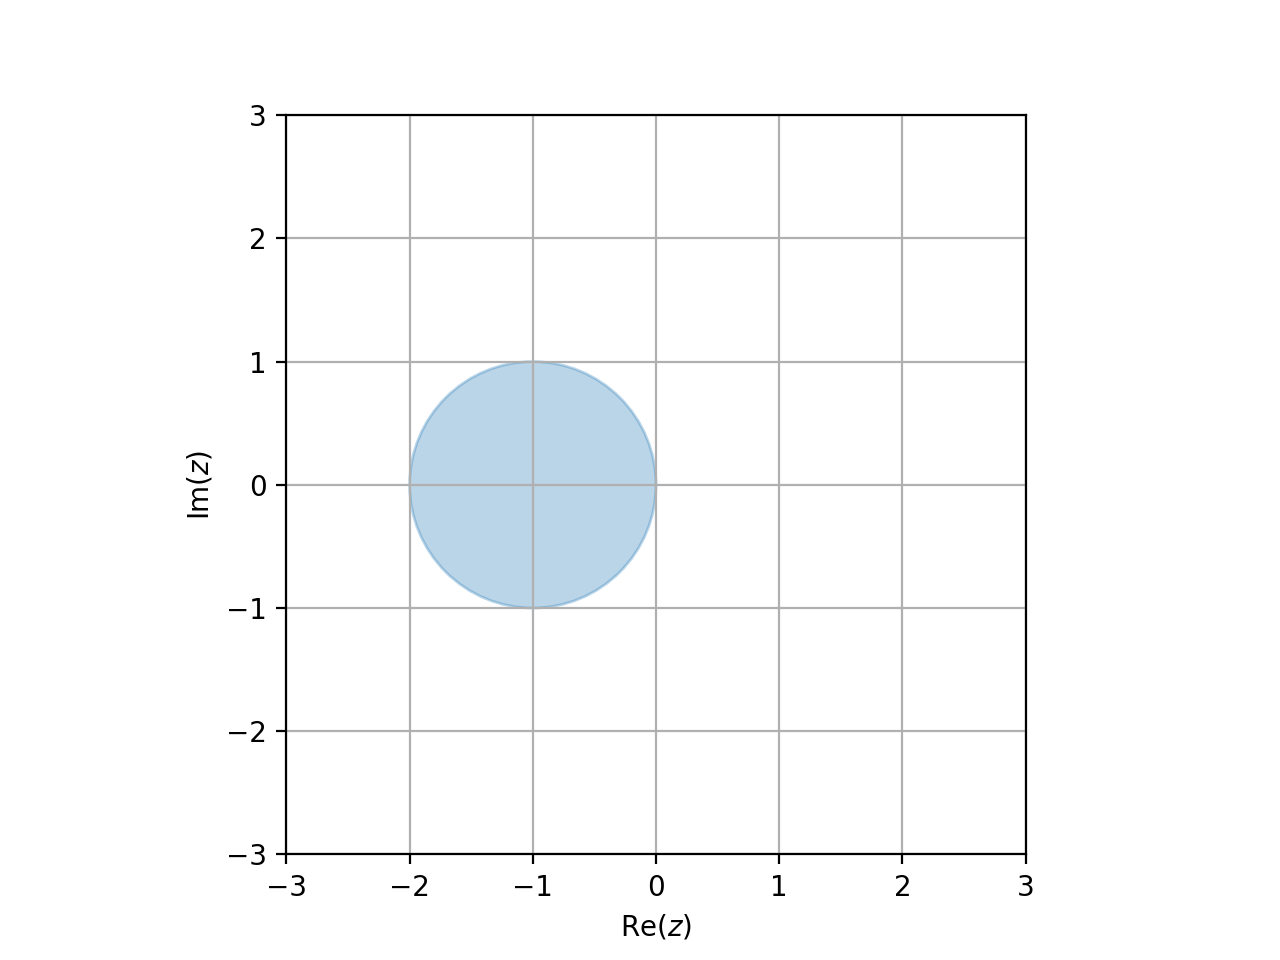

In [7]:
circle1 = plt.Circle((-1, 0), 1.0, color='C0', alpha = 0.3)
fig, ax = plt.subplots()
ax.add_patch(circle1)
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.set_xlabel("$\mathrm{Re}(z)$"); ax.set_ylabel("$\mathrm{Im}(z)$")
ax.set_aspect("equal")
plt.grid();plt.show()

The backward Euler, however, has

$$u_{n+1} = u_n + hf(t_{n+1}, u_{n+1}) = u_n\frac{1}{1-h\lambda} $$

and a stability region of $\{z \in \mathbb{C}: \left|\frac{1}{1 - z}\right| \leq 1\}$.

```{admonition} Question
What does this region look like?
```

This region is everything outside a disc centered on $z = 1$, with radius $1$:

<IPython.core.display.Javascript object>


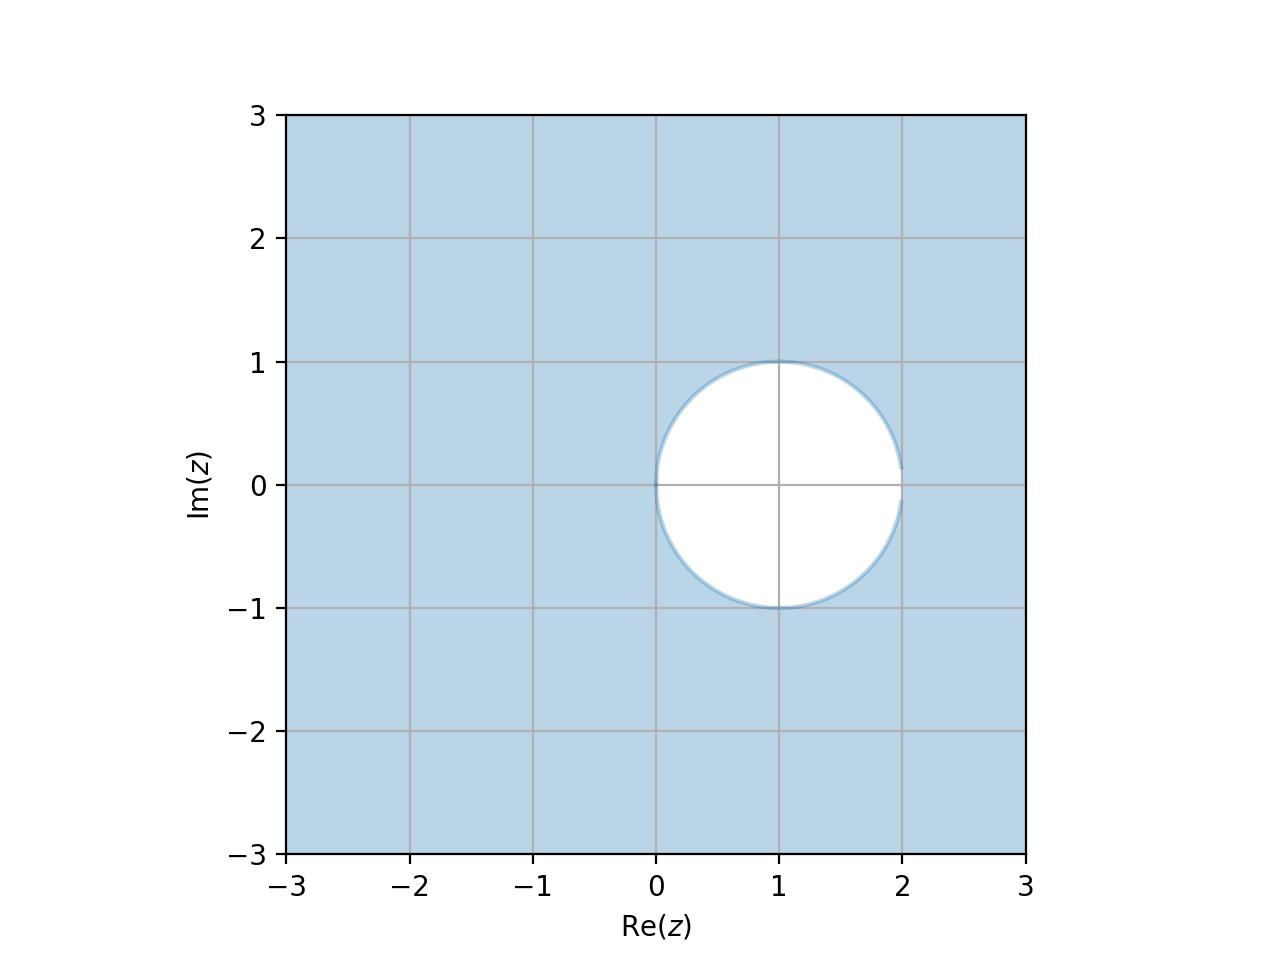

In [8]:
x = np.arange(0.0, 2, 0.01)
yp = np.sqrt(1 - (x-1)**2)
ym = -np.sqrt(1 - (x-1)**2)
fig, ax = plt.subplots()
ax.plot(x, yp, alpha = 0.3)
ax.plot(x, ym, color = 'C0', alpha = 0.3)
ax.fill_between(x, yp, 3, facecolor = 'C0', alpha = 0.3)
ax.fill_between(x, ym, -3, facecolor = 'C0', alpha = 0.3)
ax.fill_between(np.linspace(-3, 0, 200), -3, 3, facecolor = 'C0', alpha = 0.3)
ax.fill_between(np.linspace(2, 3, 200), -3, 3, facecolor = 'C0', alpha = 0.3)
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.set_xlabel("$\mathrm{Re}(z)$"); ax.set_ylabel("$\mathrm{Im}(z)$")
ax.set_aspect("equal")
plt.grid();plt.show()

```{admonition} Definition
:class: hint
A method is called A-stable if its stability region contains the entire $\mathrm{Re}(z) \leq 0$ half-plane.
```

```{admonition} Question
What condition does this express for the numerical solution? Hint: think about the successive terms of the exact solution for when $\lambda < 0$. What would happen to successive terms in the numerical solution if it weren't A-stable?
```

A-stability is a rather strong condition; it expresses the requirement that the numerical solution should be monotonically decreasing if the exact solution is monotonically decreasing.


```{admonition} Question
What can you say about the shape of the stability region of explicit (e.g. explicit Runge-Kutta) methods?
```

Since the forecasting function $\Phi_h$ of explicit methods is a polynomial in $h$, their $R(\lambda h)$ will also be a polynomial. Their stability region is therefore always bounded. 

The poor performance of explicit solvers on stiff problems can be explained as follows: their stepsize is not limited by the smoothnes of the solution, but the maximum value of $|\lambda h|$ allowed by their stability region. For example, in a very stiff problem, the solution may have a quicky decaying component with large, negative $\lambda$. This doesn't contribue to the solution significantly, since it quickly goes to zero, but limits the stepsize of an explicit method to unreasonably small values. Using implicit methods with an unbounded stability region remedies this issue.

The other phenomenon we observed was the oscillation of the stepsize $h$. This can be fixed without switching to an implicit solver, by virtue of better stepsize control. The oscillations are thanks to the solver increasing its stepsize to beyond the stability region's boundary, which in turn causes the predicted local error to be huge, resulting in the rejection of the step and drastic decrease of the stepsize. The solver then increases the stepsize again until it goes over the edge of the stability region, and the wasteful cycle repeats. It is, however, possible to tune the stepsizes such that the method stays right at the edge of its stability region.

## 8.2 Stepsize control via digital signal processing

### 8.2.1 The z-transform

### 8.2.2 The closed feedback loop

### 8.2.3 Filters

### 8.2.4 Controllers